# Square Lattice from Neighbor List

In [1]:
using Combinatorics
using CSV
using DataFrames
using Plots
using FreeBird

In [2]:
# Global variables
kB = 8.617333262e-5  # eV/K

8.617333262e-5

In [3]:
# Function to generate a 2D lattice of hydrogen atoms
function generate_2d_lattice(rows, cols, lattice_constant)
    positions = Dict{Int, Tuple{Float64, Float64}}()
    index = 1
    
    for i in 1:rows
        for j in 1:cols
            x = (i - 1) * lattice_constant
            y = (j - 1) * lattice_constant
            positions[index] = (x, y)
            index += 1
        end
    end
    return positions
end

# Function to compute first and second nearest neighbors using minimum image distance
function compute_neighbors(positions, rows, cols, lattice_constant)
    neighbors = Dict{Int, Tuple{Vector{Int}, Vector{Int}}}()
    num_atoms = rows * cols
    box_length_x = rows * lattice_constant
    box_length_y = cols * lattice_constant
    half_box_length_x = box_length_x / 2.0
    half_box_length_y = box_length_y / 2.0
    second_nearest_distance = sqrt(2) * lattice_constant

    for i in 1:num_atoms
        first_neighbors = Int[]
        second_neighbors = Int[]
        pos_i = positions[i]
        
        for j in 1:num_atoms
            if i != j
                pos_j = positions[j]
                dx = pos_j[1] - pos_i[1]
                dy = pos_j[2] - pos_i[2]
                
                # Apply minimum image convention
                if dx > half_box_length_x
                    dx -= box_length_x
                elseif dx < -half_box_length_x
                    dx += box_length_x
                end
                
                if dy > half_box_length_y
                    dy -= box_length_y
                elseif dy < -half_box_length_y
                    dy += box_length_y
                end
                
                distance = sqrt(dx^2 + dy^2)
                
                if distance <= lattice_constant
                    push!(first_neighbors, j)
                elseif distance <= second_nearest_distance
                    push!(second_neighbors, j)
                end
            end
        end
        
        neighbors[i] = (first_neighbors, second_neighbors)
    end
    
    return neighbors
end

abstract type LatticeWalkers end

mutable struct Lattice2DSystem
    lattice_type::Symbol
    dimensions::Tuple{Int64, Int64}
    num_occ_sites::Int64
    site_occupancy::Matrix{Bool}
    positions::Dict{Int, Tuple{Float64, Float64}}
    neighbors::Dict{Int, Tuple{Vector{Int}, Vector{Int}}}

    function Lattice2DSystem(lattice_type::Symbol, site_occupancy::Matrix{Bool}, lattice_constant::Float64)
        dims = size(site_occupancy)
        num_occ_sites = sum(site_occupancy)
        positions = generate_2d_lattice(dims[1], dims[2], lattice_constant)
        neighbors = compute_neighbors(positions, dims[1], dims[2], lattice_constant)
        return new(lattice_type, dims, num_occ_sites, site_occupancy, positions, neighbors)
    end

    function Lattice2DSystem(lattice_type::Symbol, dims::Tuple{Int64, Int64}, num_occ_sites::Int64, seed::Int64, lattice_constant::Float64)
        total_sites = prod(dims)
        occupancy = vcat(fill(true, num_occ_sites), fill(false, total_sites - num_occ_sites))
        Random.seed!(seed)
        shuffle!(occupancy)
        site_occupancy = reshape(occupancy, dims)
        positions = generate_2d_lattice(dims[1], dims[2], lattice_constant)
        neighbors = compute_neighbors(positions, dims[1], dims[2], lattice_constant)
        return new(lattice_type, dims, num_occ_sites, site_occupancy, positions, neighbors)
    end
end

mutable struct Lattice2DWalker
    configuration::Lattice2DSystem
    energy::Float64
    iter::Int64
    function Lattice2DWalker(configuration::Lattice2DSystem; energy=0.0, iter=0)
        return new(configuration, energy, iter)
    end
end

function interaction_energy(at::Lattice2DSystem, nn_energy::Float64, nnn_energy::Float64, adsorption_energy::Float64)
    e_adsorption = at.num_occ_sites * adsorption_energy
    e_nn = 0.0
    e_nnn = 0.0
    
    for i in 1:at.dimensions[1]
        for j in 1:at.dimensions[2]
            index = (i - 1) * at.dimensions[2] + j
            if at.site_occupancy[i, j]
                for nn in at.neighbors[index][1]
                    if at.site_occupancy[div(nn - 1, at.dimensions[2]) + 1, mod(nn - 1, at.dimensions[2]) + 1]
                        e_nn += nn_energy / 2
                    end
                end
                for nnn in at.neighbors[index][2]
                    if at.site_occupancy[div(nnn - 1, at.dimensions[2]) + 1, mod(nnn - 1, at.dimensions[2]) + 1]
                        e_nnn += nnn_energy / 2
                    end
                end
            end
        end
    end
    
    return e_adsorption + e_nn + e_nnn
end

function exact_enumeration(L::Int64, M::Int64, N::Int64, lattice_type::Symbol, nn_energy::Float64, nnn_energy::Float64, adsorption_energy::Float64, lattice_constant::Float64)
    sites = [(i, j) for i in 1:L for j in 1:M]
    all_configs = collect(combinations(sites, N))
    all_configs = [reshape([in((i, j), config) for i in 1:L, j in 1:M], L, M) for config in all_configs]
    lattices = [Lattice2DSystem(lattice_type, config, lattice_constant) for config in all_configs]

    walkers = [Lattice2DWalker(lattice) for lattice in lattices]

    for walker in walkers
        e_interaction = interaction_energy(walker.configuration, nn_energy, nnn_energy, adsorption_energy)
        walker.energy = e_interaction
    end

    energies = [walker.energy for walker in walkers]
    configurations = [walker.configuration for walker in walkers]

    return energies, configurations
end

function compute_internal_energy_versus_temperature(L::Int64, N::Int64, T_min::Float64, T_max::Float64, num_points::Int64, nn_energy::Float64, nnn_energy::Float64, adsorption_energy::Float64, lattice_constant::Float64, lattice_type::Symbol=:square)
    energies, configurations = exact_enumeration(L, L, N, lattice_type, nn_energy, nnn_energy, adsorption_energy, lattice_constant)
    
    minimum_energy = minimum(energies)
    energies = energies .- minimum_energy

    BoltzmannConstant = 8.617_333_262e-5
    temperatures = range(T_min, T_max, length=num_points)
    internal_energies = [sum(energy * exp(-energy / (BoltzmannConstant * T)) for energy in energies) / sum(exp(-energy / (BoltzmannConstant * T)) for energy in energies) for T in temperatures]
    heat_capacity = [sum((energy - U)^2 * exp(-energy / (BoltzmannConstant * T)) for energy in energies) / (BoltzmannConstant * T^2 * sum(exp(-energy / (BoltzmannConstant * T)) for energy in energies)) for (T, U) in zip(temperatures, internal_energies)]

    internal_energies = internal_energies .+ minimum_energy

    println("Temperature (K) | Internal Energy (eV) | Heat Capacity (eV/K)")
    for (T, U, C) in zip(temperatures, internal_energies, heat_capacity)
        println("$T $U $C")
    end
end

compute_internal_energy_versus_temperature (generic function with 2 methods)

In [4]:
# Define the simulation details
L = 4
M = 4
nn_energy = -0.01  # eV
nnn_energy = -0.0025  # eV
adsorption_energy = -0.04  # eV
simulation_details = "N$(L*M)_L$(L)_M$(M)_neighbor_list"  # e.g., "N16_L4_M4_neighbor_list"

# Create empty DataFrames to store the data
df_Cv = DataFrame(N = Int[], L = Int[], M = Int[], β = Float64[], T = Float64[], Cv = Float64[])
df_energies_configs = DataFrame(N = Int[], configuration = String[], energy = Float64[])

# Loop over different numbers of occupied sites
for N in 1:L*M

    # Enumerate all possible configurations of the lattice gas and calculate the energy of each configuration
    energies, configurations = exact_enumeration(L, M, N, :square, nn_energy, nnn_energy, adsorption_energy, 1.0)

    # Calculate the constant-volume heat capacity of the lattice gas
    Ts = collect(1.0:0.1:200.0)  # K
    βs = 1 ./ (kB * Ts)  # 1/eV
    ωis = ones(length(energies))

    Eis = zeros(length(energies))
    for i in 1:length(energies)
        Eis[i] = ustrip(energies[i])
    end

    dof = 0

    Cv = [cv(β, ωis, Eis, dof) / kB for β in βs]  # kB

    # Append Cv data to the DataFrame
    append!(df_Cv, DataFrame(N = N, L = L, M = M, β = βs, T = Ts, Cv = Cv))

    # Append energies and configurations to the DataFrame
    for i in 1:length(energies)
        append!(df_energies_configs, DataFrame(N = N, configuration = string(configurations[i]), energy = ustrip(energies[i])))
    end
end

# Write the DataFrames to CSV files with descriptive names
CSV.write("Cv_data_$simulation_details.csv", df_Cv)
CSV.write("energies_configs_$simulation_details.csv", df_energies_configs)

"energies_configs_N16_L4_M4_neighbor_list.csv"

## Compare Performance of Different Algorithms for Generating Neighbor List of Square Lattice

In [5]:
# Read data
energies_configs = CSV.read("energies_configs_N16_L4_M4.csv", DataFrame)
energies_configs_neighbor_list = CSV.read("energies_configs_N16_L4_M4_neighbor_list.csv", DataFrame)

# Compare the dimensions of the two DataFrames
println(size(energies_configs))
println(size(energies_configs_neighbor_list))

# Filter the DataFrames by the number of occupied sites
df_2 = filter(row -> row.N == 2, copy(energies_configs))
df_2_neighbor_list = filter(row -> row.N == 2, copy(energies_configs_neighbor_list))

# Compare the dimensions of the two filtered DataFrames
println(size(df_2))
println(size(df_2_neighbor_list))

# Compare the number of unique energies in the two filtered DataFrames
println(length(unique(df_2.energy)))
println(length(unique(df_2_neighbor_list.energy)))

# Define the countmap function
function countmap(data)
    counts = Dict{Any, Int}()
    for item in data
        counts[item] = get(counts, item, 0) + 1
    end
    return counts
end

# Compare the counts of the unique energies in the two filtered DataFrames
println(countmap(df_2.energy))
println(countmap(df_2_neighbor_list.energy))

(65535, 3)
(65535, 3)
(120, 3)
(120, 3)
3
3
Dict{Any, Int64}(-0.08 => 56, -0.0825 => 32, -0.09 => 32)
Dict{Any, Int64}(-0.08 => 56, -0.0825 => 32, -0.09 => 32)


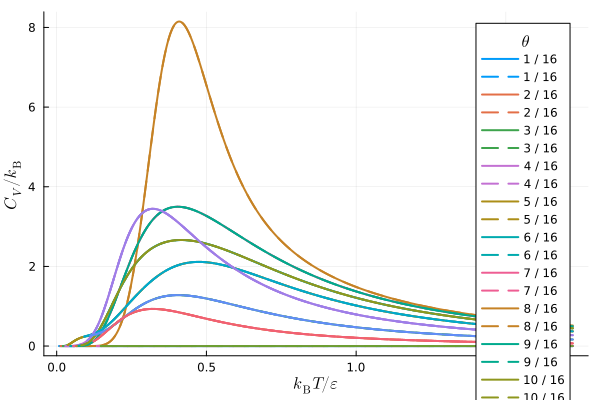

In [6]:
# Read data
Cv = CSV.read("Cv_data_N16_L4_M4.csv", DataFrame)
Cv_neighbor_list = CSV.read("Cv_data_N16_L4_M4_neighbor_list.csv", DataFrame)

# Create an empty plot
p = plot()

# Loop over different numbers of occupied sites
for N in 1:L*M

    # Extract the data for the current number of occupied sites
    df_N = filter(row -> row.N == N, copy(Cv))
    df_N_neighbor_list = filter(row -> row.N == N, copy(Cv_neighbor_list))

    # Convert the temperatures to reduced units
    Ts = kB * df_N.T / ustrip(-nn_energy)
    Ts_neighbor_list = kB * df_N_neighbor_list.T / ustrip(-nn_energy)

    # Extract the constant-volume heat capacity data
    Cv_N = df_N.Cv
    Cv_neighbor_list_N = df_N_neighbor_list.Cv

    # Create a plot of the constant-volume heat capacity as a function of temperature
    plot!(p, Ts, Cv_N, xlabel="\$ k_{\\mathrm{B}} T / ε \$", ylabel="\$ C_V / k_{\\mathrm{B}} \$", linewidth=2, size=(600, 400), label="$(N) / $(L * M)", legendtitle="\$ \\theta \$", color=N)
    plot!(p, Ts_neighbor_list, Cv_neighbor_list_N, xlabel="\$ k_{\\mathrm{B}} T / ε \$", ylabel="\$ C_V / k_{\\mathrm{B}} \$", linewidth=2, size=(600, 400), label="$(N) / $(L * M)", legendtitle="\$ \\theta \$", linestyle=:dash, color=N)
    
end

# Display the plot
display(p)

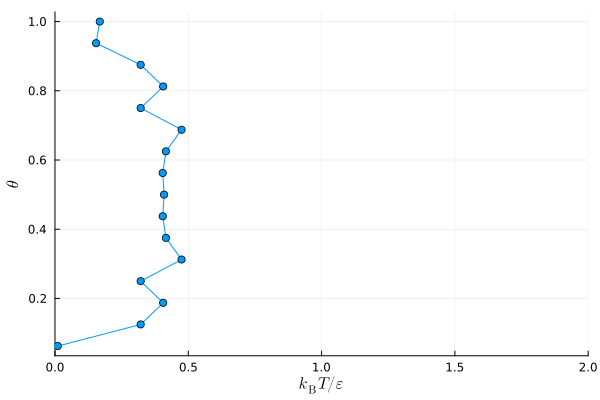

In [7]:
# Read data
Cv_neighbor_list = CSV.read("Cv_data_N16_L4_M4_neighbor_list.csv", DataFrame)

# Create an empty DataFrame to store N and T_max
peak_df = DataFrame(N = Int[], T_max = Float64[])

# Loop over different numbers of occupied sites
for N in 1:(L * M)

    # Filter the data for the current number of occupied sites
    df_N = filter(row -> row.N == N, copy(Cv_neighbor_list))

    # Remove the rows with NaN values in the Cv column
    df_N = df_N[.!isnan.(df_N.Cv), :]

    # Check if dataframe is empty
    if !isempty(df_N)
        # Find the index of the maximum heat capacity
        idx_max_Cv = argmax(df_N.Cv)
        
        # Find the temperature corresponding to the maximum heat capacity
        T_max = df_N.T[idx_max_Cv]
        
        # Append to the DataFrame
        push!(peak_df, (N, T_max))
    end
end

# Save the DataFrame to a CSV file
CSV.write("peak_temperatures.csv", peak_df)

# Plotting
Trs = kB * peak_df.T_max / ustrip(-nn_energy)
θs = peak_df.N / (L * M)
p = plot(Trs, θs, xlabel="\$ k_{\\mathrm{B}} T / ε \$", ylabel = "\$ \\theta \$", marker = :circle, legend = false, xlim=(0, 2))
display(p)